In [1]:
import networkx as nx

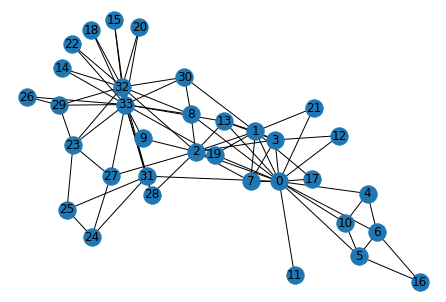

In [2]:
# Create a graph and visualize it
G = nx.karate_club_graph()

import matplotlib.pyplot as plt
nx.draw(G,with_labels=True)

In [3]:
# DG is directed version of G. Replaces each edge {i,j} by (i,j) and (j,i)
DG = nx.DiGraph(G)

# Pick some arbitrary arc costs
c = { (i,j) : i*j for (i,j) in DG.edges }

r = 0  # tree root, arbitrarily chosen

In [4]:
import gurobipy as gp
from gurobipy import GRB

In [5]:
# Create model object
m = gp.Model()

# Create x variable for each edge
x = m.addVars( DG.edges, vtype=GRB.BINARY )

# Create f variable for each vertex ("commodity") and each edge
f = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS )

# Objective function: minimize cost of selected edges
m.setObjective( gp.quicksum( c[i,j] * x[i,j] for i,j in DG.edges ), GRB.MINIMIZE )

# Constraints: each node (besides r) should have one incoming arc
m.addConstrs( gp.quicksum( x[j,i] for j in DG.neighbors(i) ) == 1 for i in G.nodes if i != r )
m.addConstr( gp.quicksum( x[j,r] for j in DG.neighbors(r) ) == 0 )

# Constraints: each node i (besides r) should consume one unit of flow *of their own type*
for i in DG.nodes:
    if i != r:
        m.addConstr( gp.quicksum( f[i,j,i] - f[i,i,j] for j in DG.neighbors(i) ) == 1 )
        m.addConstrs( gp.quicksum( f[v,j,i] - f[v,i,j] for j in DG.neighbors(i) ) == 0 for v in DG.nodes if v != i )

# Constraints: flow can only cross built edges
m.addConstrs( f[v,i,j] <= x[i,j] for i,j in DG.edges for v in DG.nodes )

# Solve
m.optimize()

Academic license - for non-commercial use only - expires 2021-07-26
Using license file C:\Users\Austin\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 6460 rows, 5460 columns and 20284 nonzeros
Model fingerprint: 0x2fb862ef
Variable types: 5304 continuous, 156 integer (156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3120 rows and 2675 columns
Presolve time: 0.35s
Presolved: 3340 rows, 2785 columns, 10990 nonzeros
Variable types: 2672 continuous, 113 integer (113 binary)
Found heuristic solution: objective 13244.000000
Found heuristic solution: objective 6775.0000000

Root relaxation: objective 6.631000e+03, 56 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

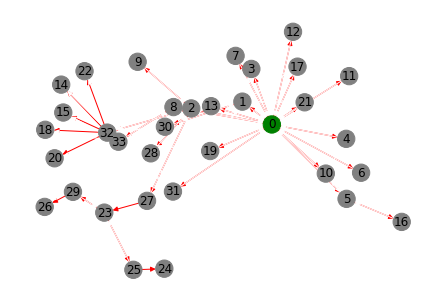

In [6]:
# Visualize the solution
tree_edges = [ (i,j) for i,j in DG.edges if x[i,j].x > 0.5 ]

edge_colors = [ "red" if i in tree_edges else "white" for i in DG.edges ]
node_colors = [ "green" if i == r else "gray" for i in DG.nodes ]

nx.draw( DG, with_labels=True, edge_color=edge_colors, node_color=node_colors )